In [761]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

# Find scripts
sys.path.insert(0, "../src/")
from cda_scripts import *

np.random.seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset loading and pre-processing (see src/cda_scripts.py)

In [762]:
# Load data
data_path = Path("../", "data")
df_raw_realized = pd.read_excel(Path(data_path,  "Realized_Schedule_20210101-20220228.xlsx"))
df_raw_future = pd.read_excel(Path(data_path, "Future_Schedule_20220301-20220331.xlsx"))

# String conversion
cat_cols = ["FlightNumber", "Destination", "Airline", "Sector", "FlightType", "AircraftType"]
df_raw_realized[cat_cols] = df_raw_realized[cat_cols].astype(str)
df_raw_future[cat_cols] = df_raw_future[cat_cols].astype(str)

In [1120]:
# Model for handling data
class DataModel():
    """
    Class for loading, processing and training ML models on Daylio exported CSV file
    """
    def __init__(self, df_raw, verbose=1):
        self.start_time = "2021-01-01"
        self.time_col = "ScheduleTime"

        self.df_raw = df_raw
        self.df_proc = None
        self.verbose = verbose

        self.X_train = None
        self.y_train = None

        self.X_valid = None
        self.y_valid = None

    def preprocess(self, cat_cols):
        df_proc = self.df_raw.copy()
        print(f"df_raw.shape: {df_proc.shape}")
        print(df_proc.columns)

        #exclude_time = "2021-02-01"
        #df_proc = filter_exclude_time(df_proc, time_col="ScheduleTime", exclude_time=exclude_time)

        # Add counts for flight and capacity monthly
        df_proc = add_flight_counts(df_proc)

        # Add feature how close to ending date range 0-1 (1 is end date)
        df_proc = add_time_delta(df_proc, start_time=self.start_time, time_col=self.time_col)

        # Create one-hot encoded time features
        df_proc = add_date_features(df_proc, self.time_col)

        # One-hot encode other features
        cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType", "FlightNumber"]
        df_proc = map_cat_as_numerical(df_proc, cat_cols, target_col="LoadFactor")

        # Exclude columns
        #exclude_cols = ["Airline", "FlightNumber"]
        #df_proc = remove_columns(df_proc, exclude_cols)

        # Normalize
        #norm_cols = ["SeatCapacity"]
        #df_proc = normalize_minmax_cols(df_proc, norm_cols)

        self.df_proc = df_proc
        print(f"df_proc.shape: {df_proc.shape}")
        print(df_proc.columns)

    def get_trainval(self, val_months, val_years):
        
        X_train, y_train, X_val, y_val = create_trainval(self.df_proc, val_months, val_years)

        return X_train, y_train, X_val, y_val


In [1010]:
df_raw = df_raw_realized.copy()
datamodel = DataModel(df_raw)

cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType"]
datamodel.preprocess(cat_cols)

val_months = [11]
val_years = [2021]
X_train, y_train, X_val, y_val = datamodel.get_trainval(val_months, val_years)
X_train

df_raw.shape: (39449, 9)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor'],
      dtype='object')
df_proc.shape: (39449, 15)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor',
       'FlightCount_week', 't_delta', 't_dayofyear', 't_dayofmonth',
       't_dayofweek', 't_timeofday'],
      dtype='object')


,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,FlightCount_week,t_delta,t_dayofyear,t_dayofmonth,t_dayofweek,t_timeofday
0,0.121046,0.185180,0.082426,-0.002625,-0.247793,-0.002552,142,2.0,0.000684,1,1,4,6.583333
1,0.052068,-0.108274,0.001456,-0.112921,-0.247793,0.017179,74,4.0,0.006160,1,1,4,10.583333
2,0.121046,0.153066,0.082426,-0.002625,-0.247793,-0.002552,142,3.0,0.008214,1,1,4,12.083333
3,0.029052,0.025634,0.034503,-0.112921,-0.247793,-0.002552,72,1.0,0.009925,1,1,4,13.333333
4,0.158585,0.160692,0.082426,0.143597,-0.247793,-0.002552,186,2.0,0.011294,1,1,4,14.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39444,0.167526,-0.155540,0.106684,0.111669,-0.247793,0.017179,144,2.0,13.914956,59,28,0,18.750000
39445,0.158585,0.008592,0.097443,0.111669,-0.247793,0.017179,156,1.0,13.915869,59,28,0,19.416667
39446,0.167526,0.142598,0.190955,0.148225,-0.247793,-0.002552,98,1.0,13.916667,59,28,0,20.000000
39447,0.158585,0.191842,0.185986,-0.083220,-0.247793,-0.002552,186,1.0,13.915983,59,28,0,19.500000


### Training Random Forest model on Feb 22 validation month

In [1021]:
val_months = [2]
val_year = [2022]
X_train, y_train, X_val, y_val = datamodel.get_trainval(val_months, val_year)

#filter_list = ["t_dayofyear"]
#X_train, y_train, X_val, y_val = filter_features(X_train, y_train, X_val, y_val, filter_list)

# Params
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

print("RF")
f = 0.50
max_features = int(len(X_train.columns) * f)
model = RandomForestRegressor(max_features=max_features, random_state=0)
model, acc_train, acc_val = fit_model(model, X_train, y_train, X_val, y_val)

Excluded Index([], dtype='object')
RF
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.178, MSE: 0.05, Pearson 0.763, Acc: 0.822


### Random Forest feature importance

/Users/maghoi/opt/anaconda3/envs/py39/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



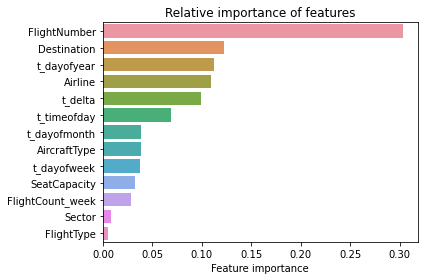

In [1026]:
coef = get_coef(model, X_train)

features = ["FlightCount", "MonthCapacity","t_delta", "FlightNumber", "SeatCapacity",
            "t_", "Aircraft_", "Destination_", "Airline_",
            "FlightType_", "Sector_", "SectorCount"]

features = X_train.columns
S = pd.Series(index=features)
for f in features:
    m = coef.index.str.contains(f)
    imp = np.round(coef[m].sort_values()[::-1].sum(), 3)
    S.loc[f] = imp

S_importance = S.sort_values()[::-1]

plt.figure()
sns.barplot(x=S_importance.values, y=S_importance.index)
plt.title("Relative importance of features")
plt.xlabel("Feature importance")

plt.tight_layout()
plt.savefig("../figures/feature_importance.pdf")

#plt.figure()
#coef = get_coef(model, X_train)
#m = coef.index.str.contains("^t_")
#time = coef[m].sort_values()[::-1]
#sns.barplot(x=time.values, y=time.index)
#plt.title("Relative importance of time features")
#plt.xlabel("Feature importance")


### Leave-one-month-out cross-validation from Jan 21 to Feb 22

In [968]:
# Leave one month out
list_acc_train = []
list_acc_val = []

for year in [2021, 2022]:
    for month in list(range(1, 12+1)):

        if year == 2022 and month >= 3:
            break

        print(f"Year {year}, month {month}")
        X_train, y_train, X_val, y_val = datamodel.get_trainval([month], [year])

        f = 0.50
        max_features = int(len(X_train.columns) * f)
        model = RandomForestRegressor(max_features=max_features, random_state=0)
        model, acc_train, acc_val = fit_model(model, X_train, y_train, X_val, y_val)

        list_acc_train.append(acc_train)
        list_acc_val.append(acc_val)

Year 2021, month 1
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.134, MSE: 0.028, Pearson 0.703, Acc: 0.866
Year 2021, month 2
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.103, MSE: 0.018, Pearson 0.85, Acc: 0.897
Year 2021, month 3
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.122, MSE: 0.028, Pearson 0.811, Acc: 0.878
Year 2021, month 4
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.138, MSE: 0.033, Pearson 0.759, Acc: 0.862
Year 2021, month 5
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.124, MSE: 0.026, Pearson 0.805, Acc: 0.876
Year 2021, month 6
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.129, MSE: 0.027, Pearson 0.804, Acc: 0.871
Year 2021, month 7
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.151, MSE: 0.036, Pearson 0.776, Acc: 0.849
Year 2021, month 8
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 

### Estimate of mean accuracy and March 2022 expected accuracy

Estimated accuracy for March 2022: 0.841


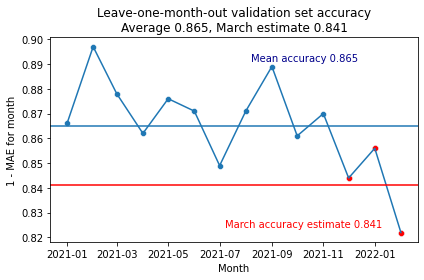

In [1118]:
df_plot = pd.DataFrame({
                        "Train_acc": list_acc_train,
                        "Val_acc": list_acc_val,
                        "Month": list(range(1, 12+1)) + list(range(1, 2+1)),
                        "Year": ["2021"]*12 + ["2022"]*2
                        })

months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
years = ["2021"]*12 + ["2022"]*2

l1 = [f"{y}.{m}" for m, y in zip(months, ["2021"]*12)]
l2 = [f"{y}.{m}" for m, y in zip(months, ["2022"]*2)]
time = pd.to_datetime(l1+l2)
df_plot["Time"] = time

ax = sns.lineplot(x=df_plot["Time"], y=df_plot["Val_acc"])
sns.scatterplot(x=df_plot["Time"], y=df_plot["Val_acc"])

plt.ylabel("1 - MAE for month")
plt.xlabel("Month")

mean_acc = df_plot.iloc[:]["Val_acc"].mean().round(3)
estimated_acc = df_plot.iloc[-3:]["Val_acc"].mean().round(3)
print(f"Estimated accuracy for March 2022: {estimated_acc}")

title = "Leave-one-month-out validation set accuracy"
subtitle = f"\nAverage {mean_acc}, March estimate {estimated_acc}"
plt.title(title+subtitle)

plt.axhline(mean_acc)
import matplotlib.dates as mdates
ax.annotate(f'Mean accuracy {mean_acc}',
            (mdates.date2num(df_plot["Time"].iloc[-7]),
            df_plot["Val_acc"].iloc[-6]), xytext=(5, 5), 
            textcoords='offset points', color="darkblue")

sns.scatterplot(x=df_plot["Time"].iloc[-3:], y=df_plot["Val_acc"].iloc[-3:],
                color="red")
plt.axhline(estimated_acc, color="red")

ax.annotate(f'March accuracy estimate {estimated_acc}',
            (mdates.date2num(df_plot["Time"].iloc[-8]),
            df_plot["Val_acc"].iloc[-1]), xytext=(5, 5), 
            textcoords='offset points', color="red")

plt.tight_layout()
plt.savefig("../figures/LOMO.pdf")